In [536]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time


#from skbio.diversity import alpha_diversity
#from skbio.diversity import beta_diversity
#from skbio import TreeNode
from io import StringIO
#from skbio.stats.ordination import pcoa
from skbio.stats.composition import ancom
import math
from skbio.stats.composition import multiplicative_replacement
import numpy as np

In [43]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.model_selection import KFold

In [3]:
import cx_Oracle

SERVER = 'dboracle.itk.ppke.hu'
PORT = 1521
SERVICE = 'rsc.itk.ppke.hu'
USER = 'metagenome'
PASSWORD = 'LrJPRUS73r84'

class Connection():

    def __init__(self):
        dsn_tns = cx_Oracle.makedsn(SERVER, PORT, service_name=SERVICE)
        self.connection = cx_Oracle.connect(USER, PASSWORD, dsn_tns)

    def get_connection(self):
        return self.connection

    def select(self, sql):
        return pd.read_sql(sql, con=self.connection)

con = Connection()

# Getting data table

In [4]:
def get_data_for_sample(path_to_file):
    dataset = path_to_file.split('/')[-1]
    df = pd.read_csv(path_to_file, delimiter = ',')
    df['Dataset'] = dataset
    df["Name"] = [n.strip() for n in df["Name"]]
    return df

In [529]:
def get_table_and_grouping(df_name, table_files, column_to_group='STUDY_CONDITION', rank='F', 
                           use_percent= True, percent=30, group=None, counts=True):

    for file in table_files:
        if df_name in file:
            index = table_files.index(file)
            
    df = get_data_for_sample(table_files[index])
    print(df.head())
    df_2 = df.loc[df['Rank'] == rank]
    
    if len(df_2) == 0:
        raise WrongRank(rank)
    
    df_2 = df_2[['Sample_ID', 'Name', 'Abundance', column_to_group]]
    df_2 = df_2.loc[[i == i for i in df_2[column_to_group]]]

    if group is not None:
        df_2[column_to_group] = [group if group in v else "Control" for v in df_2[column_to_group]]
                       
    table = df_2.pivot(index='Sample_ID', columns='Name', values='Abundance')
    
    # Dropping sparse columns
    if use_percent:
        counts = {}
        to_drop = []
        for column in table.columns:
            counts[column] = table[column].loc[table[column].notnull()].count() + table[column].loc[table[column] != 0].count()
            
            if counts[column] < table.shape[1]/100*percent:
                to_drop.append(column)
        table = table.drop(columns = to_drop)
    
    print("Shape of table:", table.shape)
    
    # Handling remaining Nan values and zero values
    table = table.fillna(0)
    table_repl = pd.DataFrame(multiplicative_replacement(table.values),
                      index=table.index,
                      columns=table.columns)
    
    # Switching from abundance to counts
    if counts:
        columns = table_repl.columns
        def calc_count(row):
            min_ab = min(row)
            to_mult = 1 / min_ab
            for col in columns:
                row[col] = round(row[col]*to_mult)
            return row

        table_repl = table_repl.apply(calc_count,axis=1)

    grouping = df_2[['Sample_ID', column_to_group]].drop_duplicates()
    grouping.index = grouping["Sample_ID"]
    grouping = grouping.drop(columns = ["Sample_ID"])
    
    grouping_ser = grouping[column_to_group]

    return table_repl, grouping_ser

In [530]:
table_repl, grouping_ser = get_table_and_grouping("FengQ_2015", files_metaphlan, rank = "p")

   Unnamed: 0  Sample_ID         Dataset Rank            Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    k        Bacteria   99.99747   
1           1  ERR688526  FengQ_2015.csv    k         Viruses    0.00253   
2           2  ERR688526  FengQ_2015.csv    p      Firmicutes   81.81372   
3           3  ERR688526  FengQ_2015.csv    p  Actinobacteria   12.04277   
4           4  ERR688526  FengQ_2015.csv    p   Bacteroidetes    4.97884   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CATEGORY  
0        adult  
1        adult  
2        adult  
3        adult  
4      

In [6]:
path_metaphlan = '//gfs/data/curated_metagenomes_metaphlan2/'

files_metaphlan = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_metaphlan):
    for file in f:
        if '.csv' in file:
            files_metaphlan.append(os.path.join(path_metaphlan, file))
print(files_metaphlan)

['//gfs/data/curated_metagenomes_metaphlan2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_metaphlan2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_metaphlan2/FengQ_2015.csv', '//gfs/data/curated_metagenomes_metaphlan2/VogtmannE_2016.csv', '//gfs/data/curated_metagenomes_metaphlan2/YuJ_2015.csv']


In [7]:
path_kraken = '//gfs/data/curated_metagenomes_kraken2/'

files_kraken = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_kraken):
    for file in f:
        if '.csv' in file:
            files_kraken.append(os.path.join(path_kraken, file))
print(files_kraken)

['//gfs/data/curated_metagenomes_kraken2/RampelliS_2015.csv', '//gfs/data/curated_metagenomes_kraken2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_kraken2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/Heitz-BuschartA_2016.csv', '//gfs/data/curated_metagenomes_kraken2/KarlssonFH_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LeChatelierE_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LiuW_2016.csv', '//gfs/data/curated_metagenomes_kraken2/LomanNJ_2013.csv', '//gfs/data/curated_metagenomes_kraken2/Obregon-TitoAJ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/QinJ_2012.csv', '//gfs/data/curated_metagenomes_kraken2/QinN_2014.csv', '//gfs/data/curated_metagenomes_kraken2/SchirmerM_2016.csv', '//gfs/data/curated_metagenomes_kraken2/VatanenT_2016.csv', '//gfs/data/curated_metagenomes_kraken2/VogtmannE_2016.csv', '//gfs/data/curated_metagenomes_kraken2/XieH_2016.csv', '//gfs/data/curated_metagenomes_kraken2

# Selbal

## Model selecting

### 1. Step: Choosing two features

In [11]:
def balance(X_i, X_j):
    if len(X_i) != len(X_j):
        raise("Columns' length not equal")
    k = len(X_i)
    B = math.sqrt(1/2)*(np.log(X_i) - np.log(X_j))
    return B

In [440]:
Bi = [0.2, 0.5, 0.05, 0.15, 0.1]
Bj = [0.1, 0.3, 0.01, 0.27, 0.31]
balance(Bi, Bj)

array([ 0.49012907,  0.36120826,  1.13804446, -0.41562794, -0.80002211])

In [12]:
def get_AUC(x_train, y_train, x_test, y_test):

    logisticRegr = LogisticRegression(solver= 'liblinear')
    logisticRegr.fit(x_train, y_train)

    #Konfidencia scoreok a teszt halmazhoz
    y_score = logisticRegr.decision_function(x_test)

    #ROC görbe számolása
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    return roc_auc

In [19]:
def opt_bal_for_two(train_table, train_target, test_table, test_target):
    Y_train = [1 if v == "CRC" else 0 for v in train_target]
    Y_test = [1 if v == "CRC" else 0 for v in test_target]
    
    max_col1 = train_table.columns[0]
    max_col2 = train_table.columns[1]
    
    max_auc = 0
    for col1 in train_table.columns:
        for col2 in train_table.columns:
            X_train = np.array(train_table[[col1,col2]])
            B_train = balance(X_train[:,0], X_train[:,1])
            
            X_test = np.array(test_table[[col1,col2]])
            B_test = balance(X_test[:,0], X_test[:,1])
            
            roc_auc = get_AUC(B_train.reshape(-1, 1), Y_train, B_test.reshape(-1, 1), Y_test)
            if roc_auc > max_auc:
                max_auc = roc_auc
                max_col1 = col1
                max_col2 = col2
    return max_col1, max_col2, max_auc

In [14]:
table_repl, grouping_ser = get_table_and_grouping("VogtmannE_2016", files_metaphlan, rank = 'g')

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(table_repl, 
     grouping_ser, test_size=0.2)

In [20]:
max_col1, max_col2, max_auc = opt_bal_for_two(X_train, y_train, X_test, y_test)

In [21]:
max_col1

'Clostridiaceae_noname'

In [22]:
max_col2

'Phascolarctobacterium'

In [23]:
max_auc

0.6873582766439911

### n. Step: Iterate to find next best feature

In [489]:
def balance_for_sets(pos_set, neg_set):
    pos_k = pos_set.shape[1]
    neg_k = neg_set.shape[1]
    
    pos_bal = np.zeros((pos_set.shape[0]))
    for k in range(pos_k):
        pos_bal = np.add(pos_bal, np.log(pos_set[:,k]))
    pos_bal = pos_bal * 1/(pos_k)
    
    neg_bal = np.zeros((neg_set.shape[0]))
    for k in range(neg_k):
        neg_bal = neg_bal+np.log(neg_set[:,k])
    neg_bal = neg_bal * 1/(neg_k)
    
    B = pos_bal - neg_bal
    return B

In [487]:
def balance_for_sets_tranposed(pos_set, neg_set):
    pos_k = pos_set.shape[0]
    neg_k = neg_set.shape[0]
        
    pos_bal = np.zeros((pos_set.shape[1]))
    
    for k in range(pos_k):
        pos_bal = np.add(pos_bal, np.log(pos_set[k,:]))
    pos_bal = pos_bal * 1/(pos_k)
    neg_bal = np.zeros((neg_set.shape[1]))
    for k in range(neg_k):
        neg_bal = neg_bal+np.log(neg_set[k,:])
    neg_bal = neg_bal * 1/(neg_k)
    
    B = pos_bal - neg_bal
    return B

In [490]:
pos_set = np.array([[0.2,0.5,0.05,0.15,0.1],[0.3,0.1,0.15,0.4,0.05]]).T
neg_set = np.array([[0.1,0.3,0.01,0.27,0.31]]).T
balance_for_sets(pos_set, neg_set).reshape(-1, 1)

array([[ 0.89587973],
       [-0.29389333],
       [ 2.15874406],
       [-0.09737204],
       [-1.4779757 ]])

In [491]:
def test_assoc(train_table, train_target, test_table, test_target, pos_set_col_names, neg_set_col_names):
    Y_train = [1 if v == "CRC" else 0 for v in train_target]
    
    pos_set_train = np.array(train_table[pos_set_col_names])
    neg_set_train = np.array(train_table[neg_set_col_names])

    B_train = balance_for_sets(pos_set_train, neg_set_train)  
    
    Y_test = [1 if v == "CRC" else 0 for v in test_target]
    
    pos_set_test = np.array(test_table[pos_set_col_names])
    neg_set_test = np.array(test_table[neg_set_col_names])
    B_test = balance_for_sets(pos_set_test, neg_set_test)

    roc_auc = get_AUC(B_train.reshape(-1, 1),Y_train, B_test.reshape(-1, 1),Y_test)
    return roc_auc

In [475]:
print(table_repl.head())
X_train, X_test, y_train, y_test = train_test_split(table_repl, 
     grouping_ser, test_size=0.2)

max_col1, max_col2, max_auc = opt_bal_for_two(X_train, y_train, X_test, y_test)
pos_set_col_names = [max_col1, "Acidaminococcus"]
neg_set_col_names = [max_col2]

Name        Acidaminococcaceae_unclassified  Acidaminococcus  Actinomyces  \
Sample_ID                                                                   
ERR1293497                         0.000142         0.000142     0.000142   
ERR1293498                         0.000142         0.000142     0.000142   
ERR1293499                         0.000142         0.000142     0.000142   
ERR1293500                         0.000142         0.000142     0.000142   
ERR1293501                         0.000142         0.000142     0.000142   

Name        Adlercreutzia  Akkermansia  Alistipes  Anaerococcus  Anaerofustis  \
Sample_ID                                                                       
ERR1293497       0.000664     0.007777   0.051931      0.000142      0.000142   
ERR1293498       0.000708     0.008262   0.055026      0.000142      0.000142   
ERR1293499       0.000614     0.008643   0.057695      0.000142      0.000142   
ERR1293500       0.000659     0.008028   0.054997      

In [492]:
test_assoc(X_train, y_train, X_test, y_test, pos_set_col_names, neg_set_col_names)

0.5643788996029495

In [115]:
def adding_new_comp(train_table, train_target, test_table, test_target, pos_set_names, neg_set_names, max_auc):
    
    columns = [col for col in train_table.columns if col not in pos_set_names 
               and col not in neg_set_names]
    max_auc_pos = 0
    max_auc_neg = 0
    which = None

    for col in columns:
        
        tmp_pos_set = []
        tmp_pos_set.extend(pos_set_names)
        tmp_pos_set.append(col)
        pos_auc = test_assoc(train_table, train_target, test_table, test_target, tmp_pos_set, neg_set_names)
        
        tmp_neg_set = []
        tmp_neg_set.extend(neg_set_names)
        tmp_neg_set.append(col)
        neg_auc = test_assoc(train_table, train_target, test_table, test_target, pos_set_names, tmp_neg_set)

        if pos_auc > neg_auc:
            if pos_auc > max_auc_pos:
                max_auc_pos = pos_auc
                pos_col = col
                which = "POS"
        else:
            if neg_auc > max_auc_neg:
                max_auc_neg = neg_auc
                neg_col = col
                which = "NEG"
    
    if which == "POS":
        pos_set_names.append(pos_col)
        max_auc_2 = max_auc_pos
    elif which == "NEG":
        neg_set_names.append(neg_col)
        max_auc_2 = max_auc_neg
        
    return pos_set_names, neg_set_names, max_auc_2
    

In [110]:
def opt_bal(train_table, train_target, test_table, test_target, threshold = 0, max_comp = 20):
    print("Optimal balance for 2...")
    max_col1, max_col2, max_auc = opt_bal_for_two(train_table, train_target, test_table, test_target)
    
    pos_set_names = [max_col1]
    neg_set_names = [max_col2]
    
    auc_list = [max_auc]
    
    comp_size = len(pos_set_names) + len(neg_set_names)
    
    crit = True
    print("Selecting further features...")
    while(crit):
        #print("Choosing feature", comp_size+1)
        tmp_pos, tmp_neg, tmp_auc = adding_new_comp(train_table, train_target, test_table, test_target,
                                                    pos_set_names, neg_set_names, max_auc)
        auc_groth = tmp_auc-max_auc
        #print("new auc", tmp_auc)
        if auc_groth > threshold:
            pos_set_names = tmp_pos
            neg_set_names = tmp_neg
            auc_list.append(tmp_auc)
            max_auc = tmp_auc
            comp_size = comp_size + 1
            crit = max_comp > comp_size
        else:
            crit = False
    return pos_set_names, neg_set_names, max_auc, auc_list, comp_size
        

In [ ]:
table_repl, grouping_ser = get_table_and_grouping("VogtmannE_2016", files_metaphlan, rank = 'g')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(table_repl, 
     grouping_ser, test_size=0.2)

In [31]:
pos_set_names, neg_set_names, max_auc, auc_list, comp_size = opt_bal(X_train, y_train, X_test, y_test,
                                                          threshold = 0, max_comp = 20)

Optimal balance for 2 ...
Choosing feature 3
new auc 0.7067901234567902
Choosing feature 4
new auc 0.7203703703703703
Choosing feature 5
new auc 0.7382716049382716
Choosing feature 6
new auc 0.7623456790123456
Choosing feature 7
new auc 0.7765432098765432
Choosing feature 8
new auc 0.8
Choosing feature 9
new auc 0.8135802469135803
Choosing feature 10
new auc 0.8191358024691359
Choosing feature 11
new auc 0.8203703703703704
Choosing feature 12
new auc 0.8339506172839506
Choosing feature 13
new auc 0.8395061728395061
Choosing feature 14
new auc 0.8413580246913581
Choosing feature 15
new auc 0.8450617283950617
Choosing feature 16
new auc 0.8450617283950617


## Testing

In [32]:
def test_model(x_train, x_test, y_train, y_test, pos_set_names, neg_set_names):
    
    Y = [1 if v == "CRC" else 0 for v in y_train]
    pos_set = np.array(x_train[pos_set_names])
    neg_set = np.array(x_train[neg_set_names])
    
    B = balance_for_sets(pos_set, neg_set)

    x_train_2 = B.reshape(-1, 1)
    y_train_2 = Y
    
    logisticRegr = LogisticRegression(solver= 'liblinear')
    logisticRegr.fit(x_train_2, y_train_2)
    
    Y_test = [1 if v == "CRC" else 0 for v in y_test]
    pos_set_test = np.array(x_test[pos_set_names])
    neg_set_test = np.array(x_test[neg_set_names])
    
    B_test = balance_for_sets(pos_set_test, neg_set_test)
    
    x_test_2 = B_test.reshape(-1, 1)
    y_test_2 = Y_test

    #Konfidencia scoreok a teszt halmazhoz
    y_score = logisticRegr.decision_function(x_test_2)

    #ROC görbe számolása
    fpr, tpr, _ = roc_curve(y_test_2, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title( 'ROC curve')
    plt.legend(loc="lower right")

    return roc_auc

In [215]:
def run_whole(dataset_name, method, rank, threshold = 0, max_comp = 20):
    
    # Find path to dataset file
    if method == "Kraken":
        table_files = files_kraken
        rank = rank.upper()
    else:
        if method == "Metaphlan":
            table_files = files_metaphlan
            rank = rank.lower()
        else:
            print("Wrong method! Method should be 'Kraken' or 'Metaphlan'")
            raise
    
    
    # Get data
    table_repl, grouping_ser = get_table_and_grouping(dataset_name, table_files, rank = rank)
    
    # Split to train and test data
    X_train, X_test, y_train, y_test = train_test_split(table_repl, 
     grouping_ser, test_size=0.2)
    
    # Model selection on train data, with validation
    X_model_train, X_validation, y_model_train, y_validation = train_test_split(X_train, 
     y_train, test_size=0.2)
    pos_set_names, neg_set_names, max_auc, auc_list, max_comp = opt_bal(X_model_train, y_model_train, X_validation, y_validation,
                                                          threshold, max_comp)
    print("Model components:", max_comp)
    print("Positive features:", pos_set_names)
    print("Negative features:", neg_set_names)
    
    # Training on training data with selected model, than test it on test data
    test_model(X_train, X_test, y_train, y_test, pos_set_names, neg_set_names)

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

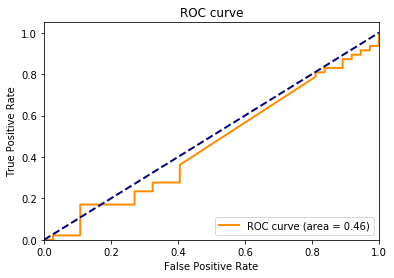

In [40]:
run_whole("VogtmannE_2016", "Metaphlan", "g", threshold=0.1)

In [100]:
table_repl, grouping_ser = get_table_and_grouping("VogtmannE_2016", files_metaphlan, rank = 'g')

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

In [83]:
indexed_table = table_repl.reset_index()
indexed_target = grouping_ser.reset_index()
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(indexed_table):
    X_train_k, X_test_k = indexed_table.loc[train_index], indexed_table.loc[test_index]
    y_train_k, y_test_k = indexed_target.loc[train_index], indexed_target.loc[test_index]

In [161]:
def cv(dataset_name, method, rank, folds = 10, threshold = 0, max_comp = 20):
    start = timeit.timeit()

    # Find path to dataset file
    if method == "Kraken":
        table_files = files_kraken
        rank = rank.upper()
    else:
        if method == "Metaphlan":
            table_files = files_metaphlan
            rank = rank.lower()
        else:
            print("Wrong method! Method should be 'Kraken' or 'Metaphlan'")
            raise
    
    
    # Get data
    table_repl, grouping_ser = get_table_and_grouping(dataset_name, table_files, rank = rank)
    
    # Split to train and test data
    X_train, X_test, y_train, y_test = train_test_split(table_repl, 
     grouping_ser, test_size=0.2)
    
    # Model selection on train data, with validation
    #indexed_table = X_train.reset_index()
    #indexed_target = y_train.reset_index()
    kf = KFold(n_splits=folds)
    i = 1
    
    cross_validation_result = []

    for train_index, test_index in kf.split(X_train):
        print("Number of fold:", i)
        X_train_k, X_test_k = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_k, y_test_k = y_train.iloc[train_index], y_train.iloc[test_index]

        pos_set_names, neg_set_names, max_auc, auc_list, comp_size = opt_bal(X_train_k, y_train_k, X_test_k, y_test_k,
                                                              threshold, max_comp)
        result = {}
        result["pos_set_names"] = pos_set_names
        result["neg_set_names"] = neg_set_names
        result["max_auc"] = max_auc
        result["auc_list"] = auc_list
        result["comp_size"] = comp_size
        cross_validation_result.append(result)
        i = i+1

    end = timeit.timeit()
    print("Elapsed time while CV:", end - start)
    return cross_validation_result
    
    # Training on training data with selected model, than test it on test data
    #test_model(X_train, X_test, y_train, y_test, pos_set_names, neg_set_names)

In [116]:
cross_validation_result = cv("VogtmannE_2016", "Metaphlan", rank = 'g', threshold = -1)

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

In [416]:
def plot_cv_auc(cross_validation_result):
    auc_lists = []
    pos_set_names = {}
    neg_set_names = {}
    max_comp = 0
    for result in cross_validation_result:
        auc_lists.append(result["auc_list"])
        for name in result["pos_set_names"]:
            if name in pos_set_names:
                pos_set_names[name] = pos_set_names[name] + 1
            else:
                pos_set_names[name] = 1
        for name in result["neg_set_names"]:
            if name in neg_set_names:
                neg_set_names[name] = neg_set_names[name] + 1
            else:
                neg_set_names[name] = 1
        if max_comp < result["comp_size"]:
            max_comp = result["comp_size"]
    
    auc_df = pd.DataFrame(auc_lists, columns = range(2,max_comp+1))
    plt.figure()
    sns.boxplot(data=auc_df)
    return auc_df

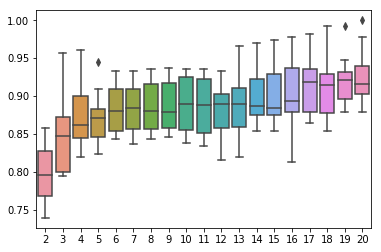

In [158]:
plot_cv_auc(cross_validation_result)

In [140]:
pos_set_names

{'Siphoviridae_noname': 2,
 'Prevotella': 2,
 'Phascolarctobacterium': 2,
 'Coprobacter': 1,
 'Flavonifractor': 2,
 'Haemophilus': 2,
 'Burkholderiales_noname': 1,
 'Methanobrevibacter': 2,
 'Pseudoflavonifractor': 3,
 'Lactococcus': 1,
 'Holdemania': 2,
 'Olsenella': 3,
 'Alistipes': 3,
 'Dorea': 1,
 'Granulicatella': 2,
 'Oxalobacter': 1,
 'C2likevirus': 3,
 'Adlercreutzia': 2,
 'Slackia': 3,
 'Anaerofustis': 1,
 'Collinsella': 2,
 'Blautia': 3,
 'Clostridiales_Family_XIII_Incertae_Sedis_unclassified': 3,
 'Faecalibacterium': 1,
 'Odoribacter': 2,
 'Atopobium': 2,
 'Rothia': 3,
 'Pseudomonas': 2,
 'Gemella': 2,
 'Gordonibacter': 2,
 'Citrobacter': 1,
 'Bacteroides': 2,
 'Bacteroidales_noname': 1,
 'Megasphaera': 1,
 'Bilophila': 1,
 'Desulfovibrio': 1,
 'Parabacteroides': 2,
 'Parvimonas': 1,
 'Eubacterium': 2,
 'Streptococcus': 1,
 'Roseburia': 1,
 'Sutterellaceae_unclassified': 2,
 'Sutterella': 1,
 'Clostridiales_noname': 3,
 'Subdoligranulum': 1,
 'Coprobacillus': 1,
 'Clostridia

In [141]:
neg_set_names

{'Sutterella': 1,
 'Slackia': 2,
 'Catenibacterium': 2,
 'Butyrivibrio': 2,
 'Desulfovibrio': 1,
 'Odoribacter': 2,
 'Dialister': 1,
 'Paraprevotella': 1,
 'Lactococcus': 3,
 'Oxalobacter': 3,
 'Dorea': 4,
 'Collinsella': 1,
 'Roseburia': 4,
 'Anaerococcus': 3,
 'Eubacterium': 1,
 'Flavonifractor': 3,
 'Gordonibacter': 1,
 'Turicibacter': 2,
 'Parvimonas': 2,
 'Mitsuokella': 1,
 'Ruminococcaceae_noname': 1,
 'Subdoligranulum': 2,
 'Bacteroides': 1,
 'C2likevirus': 1,
 'Enterobacter': 3,
 'Parabacteroides': 2,
 'Adlercreutzia': 2,
 'Streptococcus': 2,
 'Veillonella': 1,
 'Porphyromonas': 2,
 'Methanobrevibacter': 1,
 'Lachnospiraceae_noname': 1,
 'Peptostreptococcaceae_noname': 2,
 'Blautia': 3,
 'Citrobacter': 2,
 'Fusobacterium': 2,
 'Gemella': 2,
 'Solobacterium': 2,
 'Klebsiella': 1,
 'Prevotella': 1,
 'Phascolarctobacterium': 1,
 'Megasphaera': 1,
 'Siphoviridae_noname': 1,
 'Haemophilus': 1,
 'Pseudoflavonifractor': 1,
 'Sutterellaceae_unclassified': 1,
 'Coprobacter': 3,
 'Peptos

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

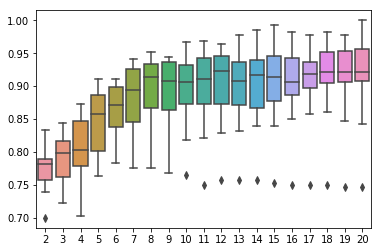

In [162]:
cross_validation_result = cv("VogtmannE_2016", "Metaphlan", rank = 'f', threshold = -1, max_comp = 20)
plot_cv_auc(cross_validation_result)

In [174]:
pos_set_names = []
neg_set_names = []
for result in cross_validation_result:
    order = 2
    for name in result["pos_set_names"]:
        pos_set_names.append([name, order])
        order = order + 1
    order = 2
    for name in result["neg_set_names"]:
        neg_set_names.append([name, order])
        order = order + 1


In [177]:
pos_order_df = pd.DataFrame(pos_set_names, columns=["Name", "Order"])

In [176]:
neg_order_df = pd.DataFrame(neg_set_names, columns=["Name", "Order"])

In [195]:
pos_order_df.groupby("Name").count().sort_values("Order", ascending=False).head()

,Order,Order_range
Name,,
Clostridiales_Family_XIII_Incertae_Sedis,7,7
Carnobacteriaceae,6,6
Siphoviridae,5,5
Ruminococcaceae,5,5
Micrococcaceae,5,5


In [196]:
neg_order_df.groupby("Name").count().sort_values("Order", ascending=False).head()

,Order
Name,
Fusobacteriaceae,5
Deinococcaceae,4
Ruminococcaceae,4
Pasteurellaceae,4
Rikenellaceae,4


In [185]:
pos_order_df["Order_range"] = [str(round(o/5)*5)+"-"for o in pos_order_df["Order"]]

In [186]:
pos_order_df.reset_index().groupby(["Name", "Order_range"]).count()

index  Order
Name                                     Order_range              
Actinomycetaceae                         0-               1      1
                                         10-              2      2
Bacillales_noname                        10-              1      1
                                         15-              1      1
                                         20-              1      1
                                         5-               1      1
Bacteroidaceae                           0-               1      1
                                         10-              1      1
Bacteroidales_noname                     5-               1      1
Brachyspiraceae                          10-              1      1
                                         5-               1      1
Burkholderiales_noname                   10-              1      1
                                         5-               1      1
Campylobacteraceae                       5-               2      2
Carnobacteriaceae                        10-              3      3
                                         5-               3      3
Clostridiaceae                           0-               1      1
Clostridiales_Family_XIII_Incertae_Sedis 10-              2      2
                                         15-              1      1
                                         5-               4      4
Clostridiales_Family_XI_Incertae_Sedis   10-              2      2
Clostridiales_noname                     0-               1      1
                                         5-               1      1
Coriobacteriaceae                        10-              1      1
                                         15-              1      1
Deinococcaceae                           15-              1      1
                                         5-               2      2
Desulfovibrionaceae                      0-               2      2
Enterobacteriaceae                       15-              2      2
Enterococcaceae                          10-              2      2
...                                                     ...    ...
Oscillospiraceae                         5-               1      1
Oxalobacteraceae                         0-               1      1
                                         10-              1      1
                                         15-              2      2
Pasteurellaceae                          10-              1      1
                                         5-               2      2
Peptostreptococcaceae                    10-              1      1
                                         5-               2      2
Porphyromonadaceae                       10-              1      1
                                         5-               3      3
Prevotellaceae                           15-              1      1
                                         5-               1      1
Pseudomonadaceae                         10-              1      1
                                         5-               3      3
Rikenellaceae                            10-              2      2
                                         5-               2      2
Ruminococcaceae                          10-              2      2
                                         5-               3      3
Siphoviridae                             0-               1      1
                                         10-              1      1
                                         5-               3      3
Streptococcaceae                         0-               1      1
                                         5-               1      1
Sutterellaceae                           10-              1      1
                                         5-               1      1
Synergistaceae                           5-               1      1
Veillonellaceae                          10-              1      1
                                  

In [197]:
pos_set_names = []
neg_set_names = []
for result in cross_validation_result:
    order = 2
    for name in result["pos_set_names"][0:5]:
        pos_set_names.append([name, order])
        order = order + 1
    order = 2
    for name in result["neg_set_names"][0:5]:
        neg_set_names.append([name, order])
        order = order + 1


In [201]:
pos_order_df = pd.DataFrame(pos_set_names, columns=["Name", "Order"])

In [203]:
pos_order_df.reset_index().groupby(["Name", "Order"]).count()

index
Name                                     Order       
Actinomycetaceae                         2          1
Bacillales_noname                        4          1
Bacteroidaceae                           2          1
Bacteroidales_noname                     6          1
Brachyspiraceae                          5          1
Campylobacteraceae                       3          1
Carnobacteriaceae                        3          1
                                         5          2
Clostridiaceae                           2          1
Clostridiales_Family_XIII_Incertae_Sedis 3          2
                                         4          1
                                         5          1
Clostridiales_noname                     2          1
                                         5          1
Deinococcaceae                           4          1
                                         6          1
Desulfovibrionaceae                      2          2
Enterococcaceae                          5          1
Fusobacteriaceae                         2          1
Lachnospiraceae                          6          1
Lactobacillaceae                         3          1
                                         5          1
                                         6          1
Leptotrichiaceae                         6          1
Leuconostocaceae                         4          1
Micrococcaceae                           5          1
Oscillospiraceae                         4          1
Oxalobacteraceae                         2          1
Pasteurellaceae                          3          1
                                         4          1
Peptostreptococcaceae                    3          1
Porphyromonadaceae                       4          1
                                         6          1
Prevotellaceae                           4          1
Pseudomonadaceae                         4          1
                                         6          2
Rikenellaceae                            5          1
                                         6          1
Ruminococcaceae                          3          2
                                         4          1
Siphoviridae                             2          1
Streptococcaceae                         2          1
                                         3          1
Synergistaceae                           6          1
Verrucomicrobiaceae                      5          1

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

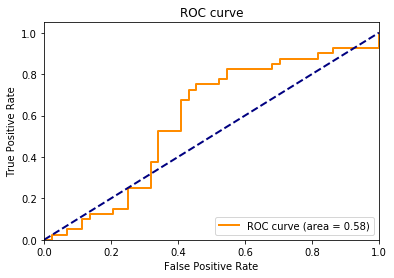

In [211]:
run_whole("VogtmannE_2016", "Metaphlan", "f", threshold=0, max_comp=5)

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

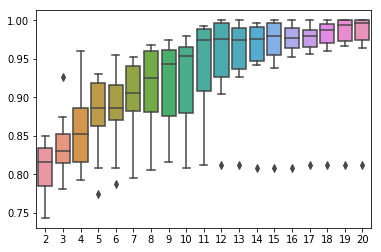

In [223]:
cross_validation_result = cv("VogtmannE_2016", "Metaphlan", rank = 'g', threshold = -1, max_comp = 20)
auc_df = plot_cv_auc(cross_validation_result)

In [225]:
auc_df.mean()

2     0.807003
3     0.838105
4     0.856784
5     0.877207
6     0.883315
7     0.895185
8     0.909749
9     0.915989
10    0.923615
11    0.945676
12    0.951476
13    0.953825
14    0.957177
15    0.961550
16    0.962197
17    0.963634
18    0.968007
19    0.971727
20    0.972139
dtype: float64

In [428]:
def map_selected_cols(cross_validation_result):
    pos_df_list = []
    neg_df_list = []
    fold_num = 0
    for result in cross_validation_result:
        order = 2
        for name in result["pos_set_names"][0:5]:
            pos_df_list.append([fold_num, order, name])
            order = order + 1
        order = 2
        for name in result["neg_set_names"][0:5]:
            neg_df_list.append([fold_num, order, name])
            order = order + 1
        fold_num = fold_num + 1
    pos_df = pd.DataFrame(pos_df_list, columns=["Fold", "Order", "Name"])
    neg_df = pd.DataFrame(neg_df_list, columns=["Fold", "Order", "Name"])
    
    pivot_count_df_neg = pd.DataFrame(neg_df.pivot(index="Name", columns="Fold", values="Order"))
    pivot_count_df_poz = pd.DataFrame(pos_df.pivot(index="Name", columns="Fold", values="Order"))
    joined = pivot_count_df_poz.join(pivot_count_df_neg, lsuffix="_POZ", rsuffix="_NEG")
    
    def poz_neg(row):
        for i in range(10):
            try:
                poz_col_name = str(i) + "_POZ"
                neg_col_name = str(i) + "_NEG"
                if row[poz_col_name] == row[poz_col_name]:
                    if row[neg_col_name] != row[neg_col_name]:
                        row["Fold_"+str(i)] = 1 #POZ
                    else:
                        print("Somethong went wrong, a column can not be in both sets!")
                        raise
                else:
                    if row[neg_col_name] == row[neg_col_name]:
                            row["Fold_"+str(i)] = -1 #NEG
                    else:
                        row["Fold_"+str(i)] = 0 #None
            except:
                pass
        return row

    joined_2 = pd.DataFrame(joined)
    joined_2 = joined_2.apply(poz_neg, axis=1)
    
    keep = []
    for col in joined_2.columns:
        if "Fold_" in col:
            keep.append(col)
    joined_3 = joined_2[keep]
    
    cols = joined_3.columns
    joined_3['Occurance'] = joined_3[cols].gt(0).sum(axis=1) + joined_3[cols].lt(0).sum(axis=1)
    #joined_3["Occurance"] = joined_3.T.count_nonzero()
    joined_3 = joined_3.sort_values("Occurance", ascending=False)
    for_plot = joined_3.drop(columns=["Occurance"])
    
    plt.figure()
    sns.heatmap(for_plot, cmap = sns.color_palette("coolwarm", 7))
    #sns.palplot(sns.color_palette("coolwarm", 7))
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    return joined_3

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold,Fold_0,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,Fold_6,Fold_7,Fold_8,Fold_9,Occurance
Name,,,,,,,,,,,
Rothia,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,-1.0,0.0,3
Klebsiella,0.0,0.0,-1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3
Peptostreptococcaceae_noname,0.0,1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3
Porphyromonas,-1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
Pseudoflavonifractor,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3
Clostridiales_Family_XIII_Incertae_Sedis_unclassified,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,3
Veillonella,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,2
Parasutterella,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
Lachnospiraceae_noname,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,2


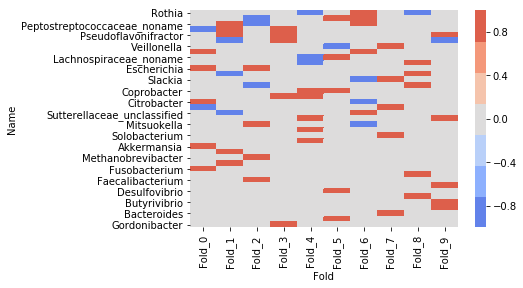

In [377]:
map_selected_cols(cross_validation_result)

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


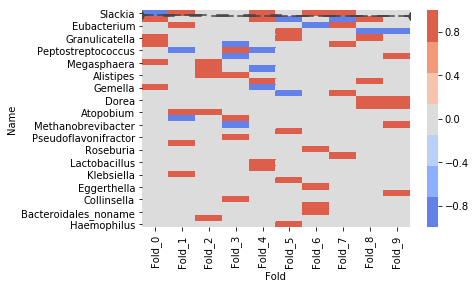

In [378]:
cross_validation_result = cv("VogtmannE_2016", "Metaphlan", rank = 'g', threshold = -1, max_comp = 20)


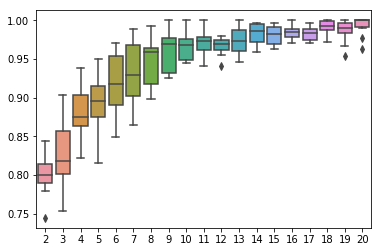

In [379]:
auc_df = plot_cv_auc(cross_validation_result)


/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


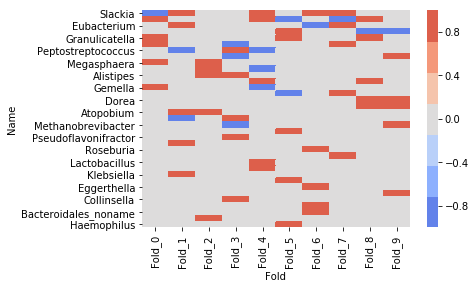

In [380]:
heamap = map_selected_cols(cross_validation_result)

In [382]:
cross_validation_result = cv("VogtmannE_2016", "Metaphlan", rank = 'f', 
                             threshold = -1, max_comp = 20)

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

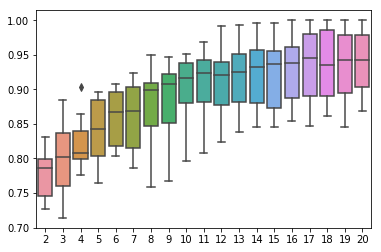

In [383]:
auc_df = plot_cv_auc(cross_validation_result)


/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


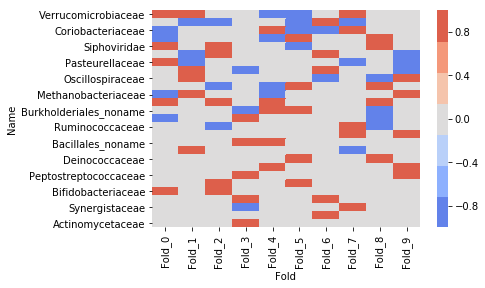

In [384]:
heamap = map_selected_cols(cross_validation_result)

In [385]:
cross_validation_result = cv("VogtmannE_2016", "Metaphlan", rank = 'c', 
                             threshold = -1, max_comp = 20)

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

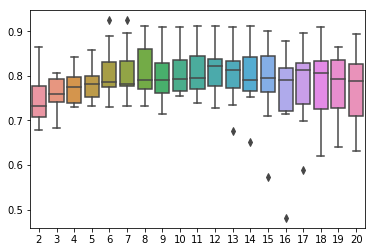

In [386]:
auc_df = plot_cv_auc(cross_validation_result)

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


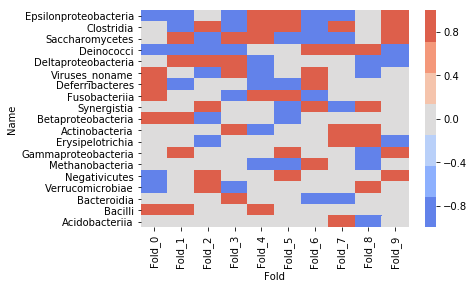

In [387]:
heamap = map_selected_cols(cross_validation_result)

In [388]:
cross_validation_result = cv("VogtmannE_2016", "Metaphlan", rank = 'p', 
                             threshold = -1, max_comp = 10)

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

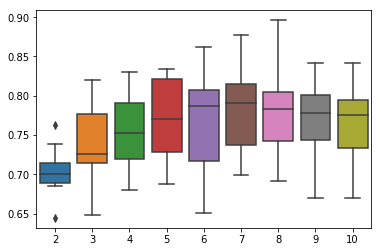

In [389]:
auc_df = plot_cv_auc(cross_validation_result)

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


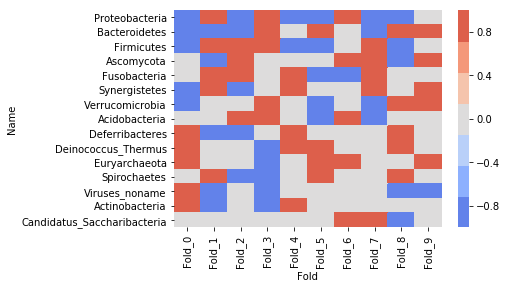

In [390]:
heamap = map_selected_cols(cross_validation_result)

In [391]:
cross_validation_result = cv("VogtmannE_2016", "Metaphlan", rank = 's', threshold = -1,
                             max_comp = 20)

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

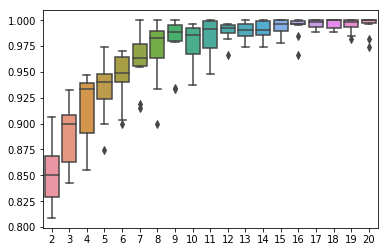

In [392]:
auc_df = plot_cv_auc(cross_validation_result)

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


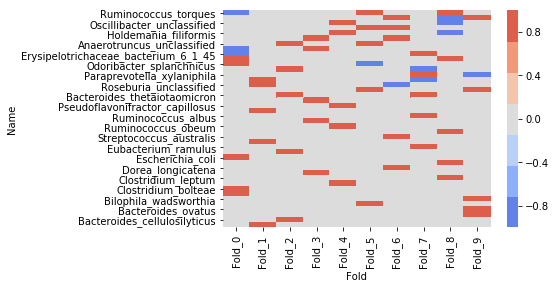

In [393]:
heamap = map_selected_cols(cross_validation_result)

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

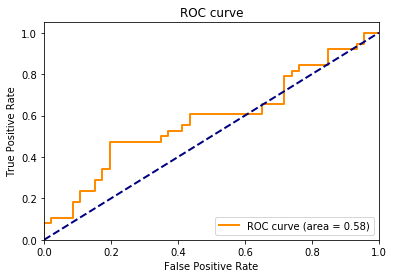

In [396]:
run_whole("VogtmannE_2016", "Metaphlan", "f", threshold=0, max_comp=20)

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

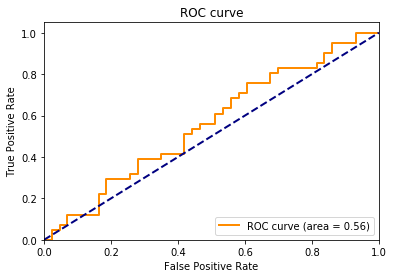

In [222]:
run_whole("VogtmannE_2016", "Metaphlan", "g", threshold=0, max_comp=20)

### Optimal number of variables
define the optimal number of variables included in the balance as the lowest number whose mean AUC is within 1 standard error of the maximum mean AUC)

In [219]:
auc_df.head()

,2,3,4,5,6,7,8,9,10
0,0.661458,0.687500,0.708333,0.687500,0.743056,0.750000,0.770833,0.774306,0.725694
1,0.693676,0.679842,0.707510,0.731225,0.727273,0.786561,0.790514,0.790514,0.786561
2,0.838596,0.814035,0.778947,0.768421,0.722807,0.680702,0.656140,0.656140,0.712281
3,0.703846,0.719231,0.676923,0.734615,0.761538,0.765385,0.769231,0.780769,0.776923
4,0.703008,0.718045,0.721805,0.714286,0.714286,0.703008,0.657895,0.725564,0.748120
5,0.788462,0.834615,0.800000,0.830769,0.842308,0.853846,0.853846,0.861538,0.865385
6,0.751852,0.781481,0.796296,0.800000,0.796296,0.833333,0.837037,0.851852,0.844444
7,0.686508,0.698413,0.706349,0.690476,0.694444,0.654762,0.682540,0.678571,0.686508
8,0.763158,0.763158,0.763158,0.763158,0.755639,0.729323,0.703008,0.695489,0.721805
9,0.716912,0.764706,0.845588,0.867647,0.871324,0.849265,0.808824,0.830882,0.830882


In [407]:
a_l = list(auc_df.mean())
a_l.index(max(a_l))+2

17

In [406]:
auc_df.mean()

2     0.850770
3     0.889191
4     0.916505
5     0.933177
6     0.944473
7     0.962060
8     0.970332
9     0.979500
10    0.977627
11    0.983558
12    0.989114
13    0.989640
14    0.990828
15    0.993028
16    0.993267
17    0.996558
18    0.996264
19    0.995167
20    0.995207
dtype: float64

In [415]:
# Standard error of mean
np.std(auc_df)/np.sqrt(19)

2     0.006714
3     0.006857
4     0.007116
5     0.006204
6     0.005441
7     0.006051
8     0.006863
9     0.005444
10    0.004681
11    0.004255
12    0.001985
13    0.001765
14    0.001871
15    0.001866
16    0.002237
17    0.000909
18    0.001089
19    0.001470
20    0.002038
dtype: float64

In [435]:
def cv_with_test(dataset_name, method, rank, folds = 10, threshold = 0, max_comp = 20, percent=30):
    start = time.time()

    # Find path to dataset file
    if method == "Kraken":
        table_files = files_kraken
        rank = rank.upper()
    else:
        if method == "Metaphlan":
            table_files = files_metaphlan
            rank = rank.lower()
        else:
            print("Wrong method! Method should be 'Kraken' or 'Metaphlan'")
            raise
    
    
    # Get data
    table_repl, grouping_ser = get_table_and_grouping(dataset_name, table_files, rank = rank, percent=percent)
    
    # Split to train and test data
    X_train, X_test, y_train, y_test = train_test_split(table_repl, 
     grouping_ser, test_size=0.2)
    
    # Model selection on train data, with validation
    kf = KFold(n_splits=folds)
    i = 1
    
    cross_validation_result = []

    for train_index, test_index in kf.split(X_train):
        print("Number of fold:", i)
        X_train_k, X_test_k = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_k, y_test_k = y_train.iloc[train_index], y_train.iloc[test_index]

        pos_set_names, neg_set_names, max_auc, auc_list, comp_size = opt_bal(X_train_k, y_train_k, X_test_k, y_test_k,
                                                              threshold=-1, max_comp=max_comp)
        result = {}
        result["pos_set_names"] = pos_set_names
        result["neg_set_names"] = neg_set_names
        result["max_auc"] = max_auc
        result["auc_list"] = auc_list
        result["comp_size"] = comp_size
        cross_validation_result.append(result)
        i = i+1

    end = time.time()
    print("Elapsed time while CV:", end - start)
    
    #Plots for model selection
    auc_df = plot_cv_auc(cross_validation_result)
    heamap_df = map_selected_cols(cross_validation_result)
    
    # Select comp size (max mean)
    a_l = list(auc_df.mean())
    max_auc_comp_size = a_l.index(max(a_l))+2
    print("Selected cmop size (max mean):", max_auc_comp_size)
    
    # Select comp size (define the optimal number of variables included in the
    #balance as the lowest number whose mean AUC is within 1 standard error of
    # the maximum mean AUC)
    
    # Standard error of mean 
    #np.std(auc_df)/np.sqrt(19)
    # BUT WHERE IS MAXIUMUM?!?!
        # Well I dont care it won't be good anyway....
    
    
    # Train on selected comp size
    X_train_mod, X_test_mod, y_train_mod, y_test_mod = train_test_split(X_train, 
     y_train, test_size=0.2)
    
    pos_set_names, neg_set_names, max_auc, auc_list, comp_size = opt_bal(X_train_mod, 
        y_train_mod, X_test_mod, y_test_mod, threshold, max_auc_comp_size)
    
    print("Positive set:", pos_set_names)
    print("Negative set:", neg_set_names)
    # Training on training data with selected model, than test it on test data
    test_model(X_train, X_test, y_train, y_test, pos_set_names, neg_set_names)
    end2 = time.time()
    print("Elapsed time whole:", end2 - start)

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Selected cmop size: 20
Optimal balance for 2 ...
Selecting further features...


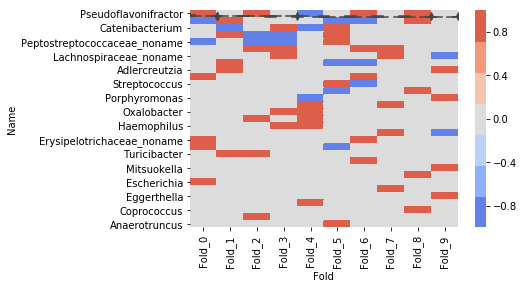

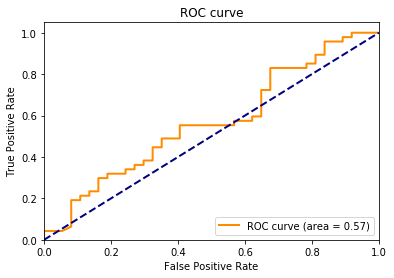

In [411]:
cv_with_test("VogtmannE_2016", "Metaphlan", "g", threshold = 0, max_comp = 20)

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Selected cmop size (max mean): 10
Optimal balance for 2 ...
Selecting further features...
Positive set: ['Eubacteriaceae', 'Sutterellaceae', 'Micrococcaceae']
Negative set: ['Lachnospiraceae']


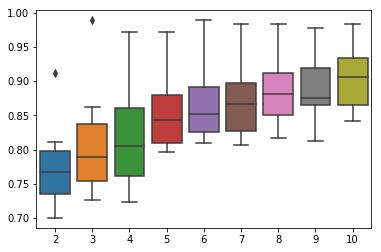

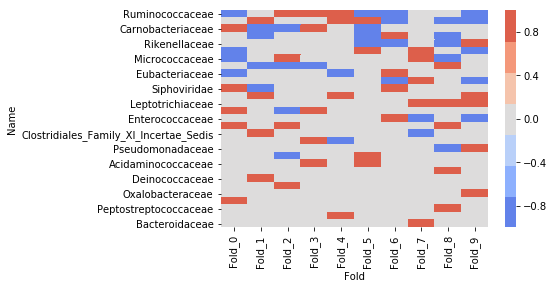

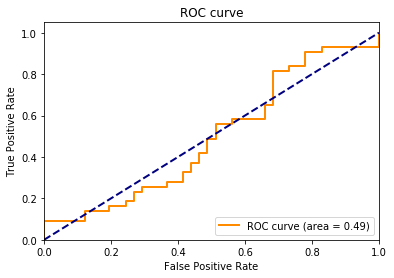

In [425]:
cv_with_test("VogtmannE_2016", "Metaphlan", "f", threshold = 0, max_comp = 10)

   Unnamed: 0   Sample_ID             Dataset Rank                Name  \
0           0  ERR1293543  VogtmannE_2016.csv    U        unclassified   
1           1  ERR1293543  VogtmannE_2016.csv    R                root   
2           2  ERR1293543  VogtmannE_2016.csv   R1  cellular organisms   
3           3  ERR1293543  VogtmannE_2016.csv    D            Bacteria   
4           4  ERR1293543  VogtmannE_2016.csv   D1           FCB group   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0      65.00             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1      35.00             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2      35.00             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3      34.95             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4      19.66             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2 

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Selected cmop size (max mean): 19
Optimal balance for 2 ...
Selecting further features...
Positive set: ['Lentisphaerae', 'Firmicutes', 'Thermotogae']
Negative set: ['Verrucomicrobia', 'Fusobacteria', 'Chordata']
Elapsed time whole: 45.70341229438782


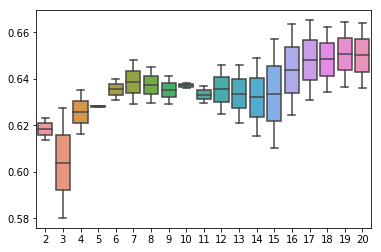

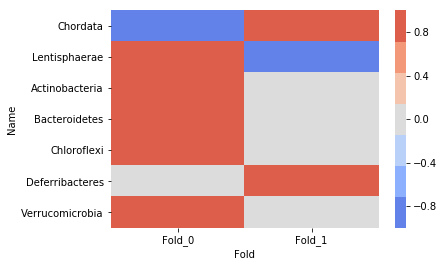

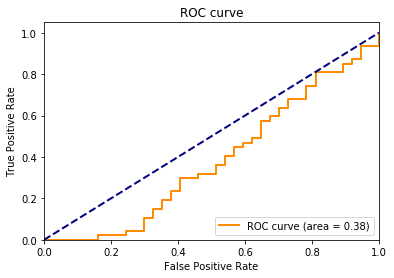

In [429]:
cv_with_test("VogtmannE_2016", "Kraken", "p", folds= 2, threshold = 0, max_comp = 20)

   Unnamed: 0   Sample_ID             Dataset Rank                Name  \
0           0  ERR1293543  VogtmannE_2016.csv    U        unclassified   
1           1  ERR1293543  VogtmannE_2016.csv    R                root   
2           2  ERR1293543  VogtmannE_2016.csv   R1  cellular organisms   
3           3  ERR1293543  VogtmannE_2016.csv    D            Bacteria   
4           4  ERR1293543  VogtmannE_2016.csv   D1           FCB group   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0      65.00             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1      35.00             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2      35.00             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3      34.95             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4      19.66             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2 

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Selected cmop size (max mean): 15
Optimal balance for 2 ...
Selecting further features...
Positive set: ['Actinobacteria', 'Erysipelotrichia', 'Spirochaetia', 'Negativicutes', 'Synergistia', 'Thermoplasmata', 'Methanobacteria']
Negative set: ['Bacilli', 'Sphingobacteriia']
Elapsed time whole: 120.54807686805725


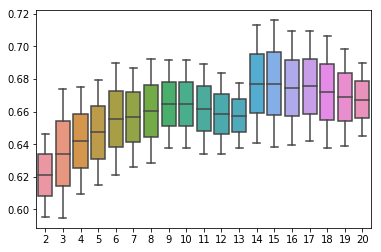

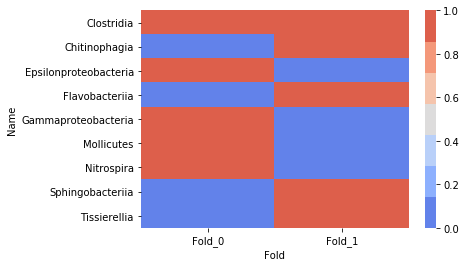

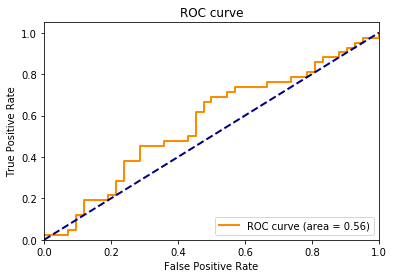

In [430]:
cv_with_test("VogtmannE_2016", "Kraken", "c", folds= 2, threshold = 0, max_comp = 20)

   Unnamed: 0   Sample_ID             Dataset Rank                Name  \
0           0  ERR1293543  VogtmannE_2016.csv    U        unclassified   
1           1  ERR1293543  VogtmannE_2016.csv    R                root   
2           2  ERR1293543  VogtmannE_2016.csv   R1  cellular organisms   
3           3  ERR1293543  VogtmannE_2016.csv    D            Bacteria   
4           4  ERR1293543  VogtmannE_2016.csv   D1           FCB group   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0      65.00             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1      35.00             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2      35.00             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3      34.95             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4      19.66             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2 

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Selected cmop size (max mean): 20
Optimal balance for 2 ...
Selecting further features...
Positive set: ['Lachnospiraceae', 'Morganellaceae', 'Hafniaceae', 'Clostridiaceae', 'Dehalococcoidaceae', 'Dysgonamonadaceae']
Negative set: ['Leptotrichiaceae', 'Enterococcaceae', 'Paludibacteraceae', 'Entomoplasmataceae', 'Erysipelotrichaceae']
Elapsed time whole: 1800.881052017212


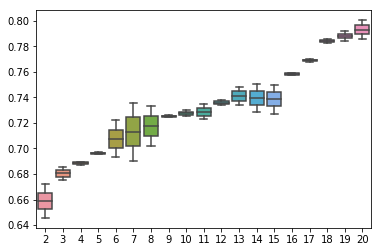

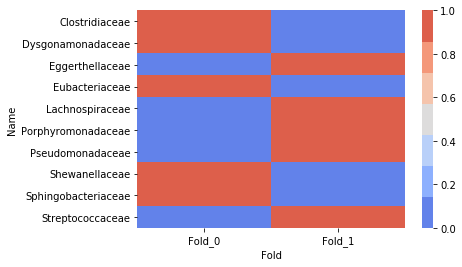

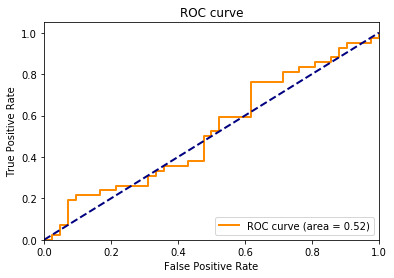

In [431]:
cv_with_test("VogtmannE_2016", "Kraken", "f", folds= 2, threshold = 0, max_comp = 20)

   Unnamed: 0   Sample_ID             Dataset Rank                Name  \
0           0  ERR1293543  VogtmannE_2016.csv    U        unclassified   
1           1  ERR1293543  VogtmannE_2016.csv    R                root   
2           2  ERR1293543  VogtmannE_2016.csv   R1  cellular organisms   
3           3  ERR1293543  VogtmannE_2016.csv    D            Bacteria   
4           4  ERR1293543  VogtmannE_2016.csv   D1           FCB group   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0      65.00             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1      35.00             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2      35.00             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3      34.95             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4      19.66             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2 

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Selected cmop size (max mean): 20
Optimal balance for 2 ...
Selecting further features...
Positive set: ['Citrobacter', 'Fusobacterium', 'Pseudomonas', 'Olsenella', 'Phoenicibacter']
Negative set: ['Streptococcus', 'Roseburia', 'Hymenobacter', 'Mogibacterium', 'Selenomonas', 'Sutterella']
Elapsed time whole: 149.21803855895996


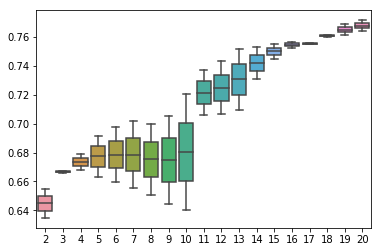

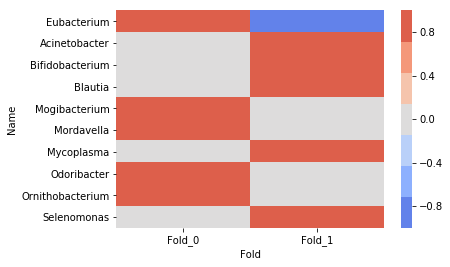

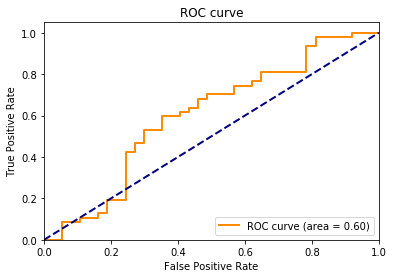

In [432]:
cv_with_test("VogtmannE_2016", "Kraken", "g", folds= 2, threshold = 0, max_comp = 20)

   Unnamed: 0   Sample_ID             Dataset Rank                Name  \
0           0  ERR1293543  VogtmannE_2016.csv    U        unclassified   
1           1  ERR1293543  VogtmannE_2016.csv    R                root   
2           2  ERR1293543  VogtmannE_2016.csv   R1  cellular organisms   
3           3  ERR1293543  VogtmannE_2016.csv    D            Bacteria   
4           4  ERR1293543  VogtmannE_2016.csv   D1           FCB group   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0      65.00             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1      35.00             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2      35.00             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3      34.95             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4      19.66             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2 

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Selected cmop size (max mean): 20
Optimal balance for 2 ...
Selecting further features...
Positive set: ['Bacteroides zoogleoformans', '[Eubacterium] rectale', '[Clostridium] bolteae']
Negative set: ['Clostridiales bacterium CCNA10', 'Ethanoligenens harbinense']
Elapsed time whole: 153.85046005249023


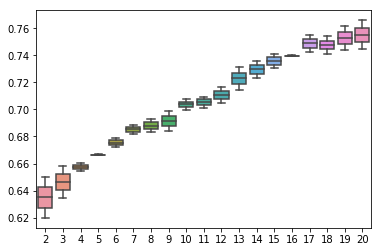

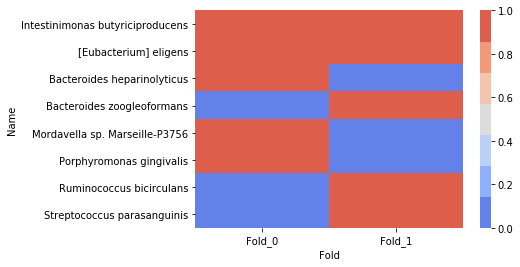

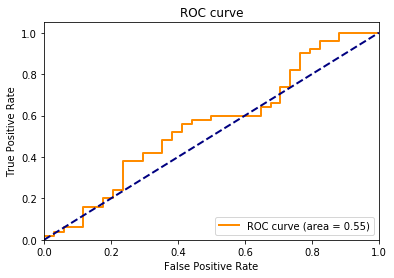

In [437]:
cv_with_test("VogtmannE_2016", "Kraken", "s", folds= 2, threshold = 0, max_comp = 20,
             percent=10)

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Selected cmop size (max mean): 19
Optimal balance for 2 ...
Selecting further features...
Positive set: ['Bifidobacterium_adolescentis', 'Lachnospiraceae_bacterium_1_1_57FAA', 'Coprococcus_sp_ART55_1', 'Desulfovibrio_piger', 'Bacteroides_xylanisolvens', 'Coprococcus_catus', 'Oxalobacter_formigenes']
Negative set: ['Eubacterium_eligens', 'Odoribacter_splanchnicus', 'Butyrivibrio_crossotus', 'Lachnospiraceae_bacterium_5_1_63FAA', 'Paraprevotella_clara', 'Streptococcus_salivarius', 'Paraprevotella_unclassified', 'Bacteroides_stercoris', 'Methanobrevibacter_unclassified']
Elapsed time whole: 304.3767042160034


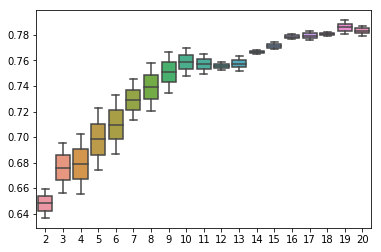

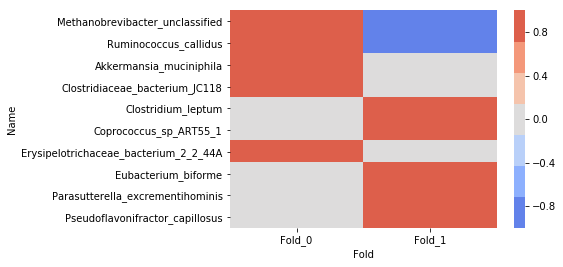

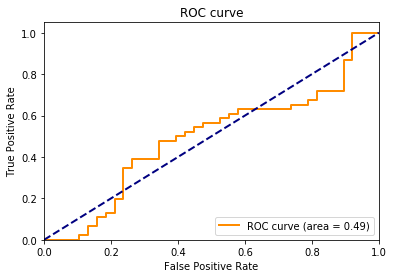

In [439]:
cv_with_test("VogtmannE_2016", "Metaphlan", "s", folds= 2, threshold = 0, max_comp = 20,
             percent=30)

In [493]:
print(files_metaphlan)

['//gfs/data/curated_metagenomes_metaphlan2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_metaphlan2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_metaphlan2/FengQ_2015.csv', '//gfs/data/curated_metagenomes_metaphlan2/VogtmannE_2016.csv', '//gfs/data/curated_metagenomes_metaphlan2/YuJ_2015.csv']


   Unnamed: 0  Sample_ID         Dataset Rank            Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    k        Bacteria   99.99747   
1           1  ERR688526  FengQ_2015.csv    k         Viruses    0.00253   
2           2  ERR688526  FengQ_2015.csv    p      Firmicutes   81.81372   
3           3  ERR688526  FengQ_2015.csv    p  Actinobacteria   12.04277   
4           4  ERR688526  FengQ_2015.csv    p   Bacteroidetes    4.97884   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CATEGORY  
0        adult  
1        adult  
2        adult  
3        adult  
4      

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Selected cmop size (max mean): 20
Optimal balance for 2 ...
Selecting further features...
Positive set: ['Eggerthella_unclassified', 'Streptococcus_mitis_oralis_pneumoniae']
Negative set: ['Subdoligranulum_variabile', 'Veillonella_parvula', 'Granulicatella_unclassified', 'Lachnospiraceae_bacterium_7_1_58FAA', 'Erysipelotrichaceae_bacterium_6_1_45']
Elapsed time whole: 94.76270413398743


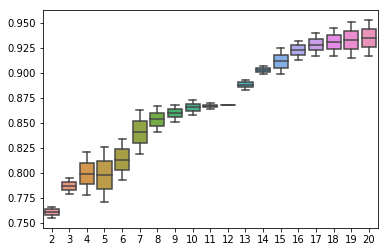

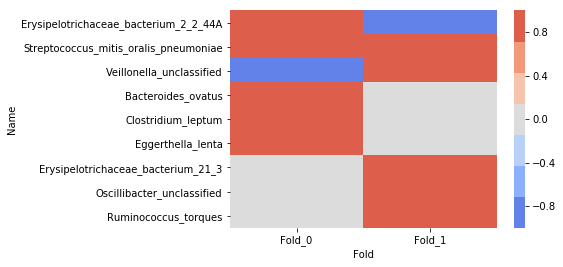

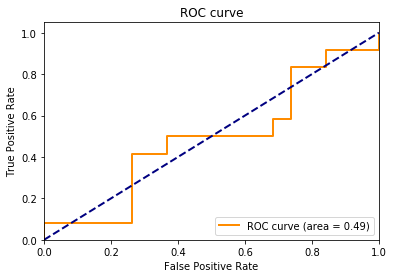

In [494]:
cv_with_test("FengQ_2015", "Metaphlan", "s", folds= 2, threshold = 0, max_comp = 20,
             percent=30)

   Unnamed: 0  Sample_ID         Dataset Rank            Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    k        Bacteria   99.99747   
1           1  ERR688526  FengQ_2015.csv    k         Viruses    0.00253   
2           2  ERR688526  FengQ_2015.csv    p      Firmicutes   81.81372   
3           3  ERR688526  FengQ_2015.csv    p  Actinobacteria   12.04277   
4           4  ERR688526  FengQ_2015.csv    p   Bacteroidetes    4.97884   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CATEGORY  
0        adult  
1        adult  
2        adult  
3        adult  
4      

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Selected cmop size (max mean): 15
Optimal balance for 2 ...
Selecting further features...
Positive set: ['Methanobacteriaceae', 'Saccharomycetaceae', 'Retroviridae', 'Deinococcaceae', 'Candidatus_Saccharibacteria_noname']
Negative set: ['Pseudomonadaceae', 'Burkholderiaceae']
Elapsed time whole: 92.6779727935791


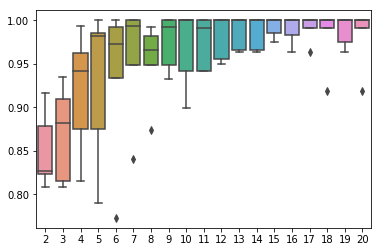

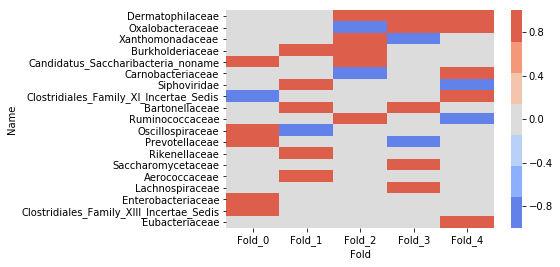

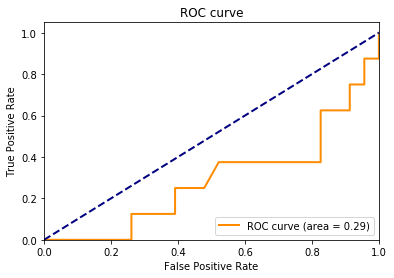

In [496]:
cv_with_test("FengQ_2015", "Metaphlan", "f", folds= 5, threshold = 0, max_comp = 20,
             percent=30)

   Unnamed: 0  Sample_ID         Dataset Rank            Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    k        Bacteria   99.99747   
1           1  ERR688526  FengQ_2015.csv    k         Viruses    0.00253   
2           2  ERR688526  FengQ_2015.csv    p      Firmicutes   81.81372   
3           3  ERR688526  FengQ_2015.csv    p  Actinobacteria   12.04277   
4           4  ERR688526  FengQ_2015.csv    p   Bacteroidetes    4.97884   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CATEGORY  
0        adult  
1        adult  
2        adult  
3        adult  
4      

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Selected cmop size (max mean): 20
Optimal balance for 2 ...
Selecting further features...
Positive set: ['Porphyromonadaceae', 'Potyviridae', 'Erysipelotrichaceae', 'Fusobacteriaceae', 'Dermatophilaceae']
Negative set: ['Pseudomonadaceae']
Elapsed time whole: 92.36345291137695


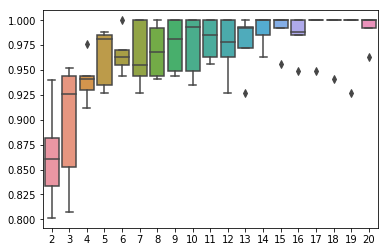

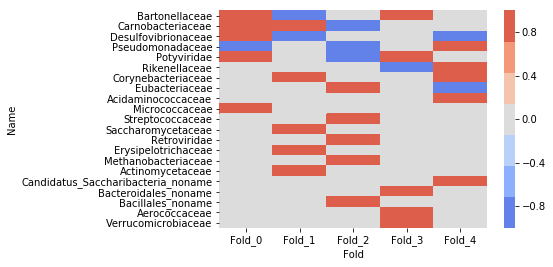

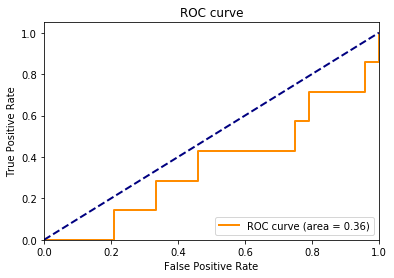

In [531]:
cv_with_test("FengQ_2015", "Metaphlan", "f", folds= 5, threshold = 0, max_comp = 20,
             percent=30)

   Unnamed: 0  Sample_ID         Dataset Rank            Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    k        Bacteria   99.99747   
1           1  ERR688526  FengQ_2015.csv    k         Viruses    0.00253   
2           2  ERR688526  FengQ_2015.csv    p      Firmicutes   81.81372   
3           3  ERR688526  FengQ_2015.csv    p  Actinobacteria   12.04277   
4           4  ERR688526  FengQ_2015.csv    p   Bacteroidetes    4.97884   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CATEGORY  
0        adult  
1        adult  
2        adult  
3        adult  
4      

/gfs/progs/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Selected cmop size (max mean): 13
Optimal balance for 2 ...
Selecting further features...
Positive set: ['Candidatus_Saccharibacteria_noname', 'Betaproteobacteria', 'Acidobacteriia', 'Saccharomycetes', 'Methanobacteria', 'Alphaproteobacteria', 'Erysipelotrichia', 'Verrucomicrobiae', 'Epsilonproteobacteria']
Negative set: ['Gammaproteobacteria', 'Deltaproteobacteria', 'Bacteroidia', 'Fusobacteriia']
Elapsed time whole: 19.70325016975403


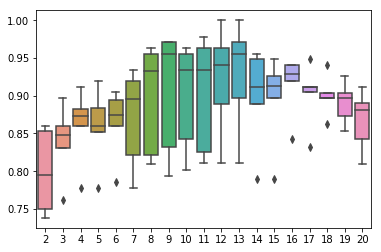

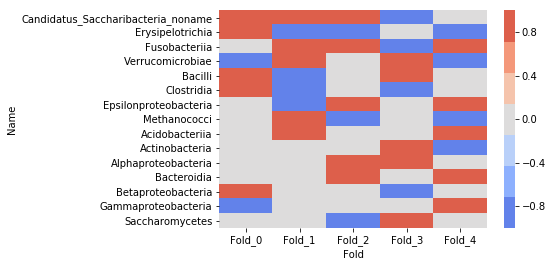

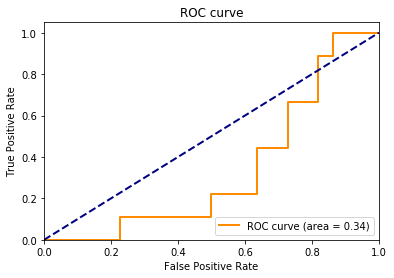

In [533]:
cv_with_test("FengQ_2015", "Metaphlan", "c", folds= 5, threshold = -1, max_comp = 20,
             percent=30)

In [534]:
%run example.py

This one have runned.


In [535]:
printing_hello()

Hello world!
